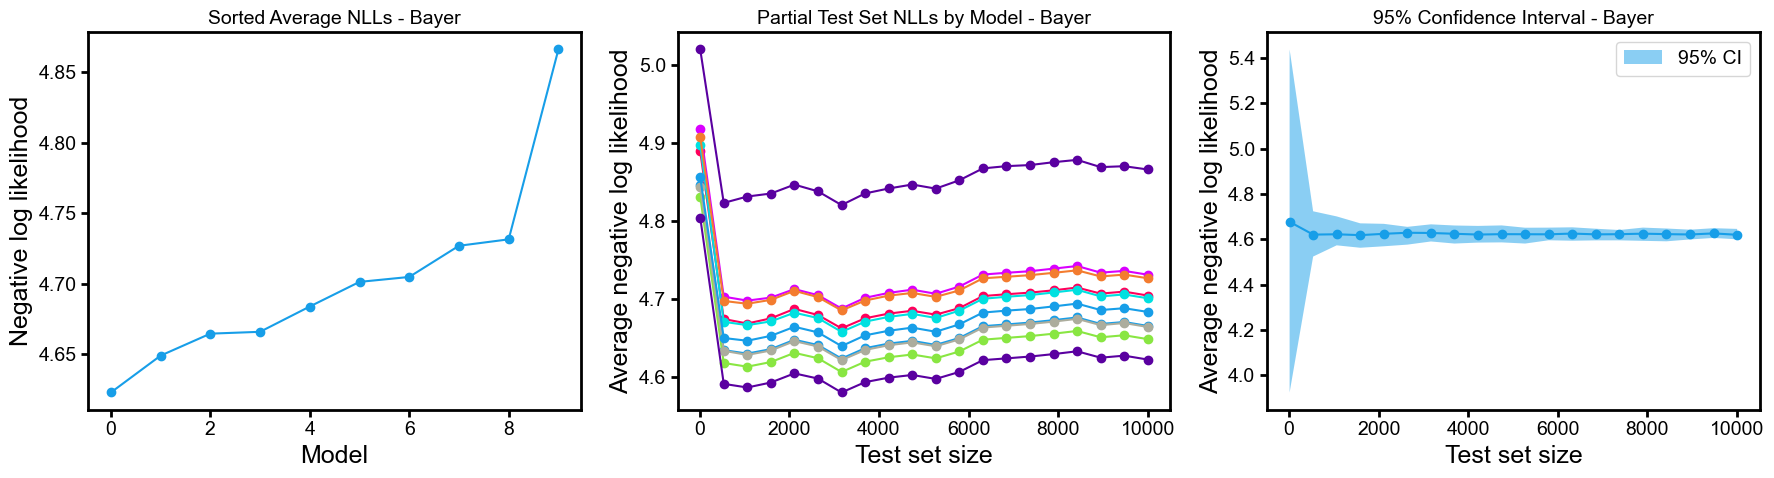

Results for Bayer:
Mutual information: 0.9098 bits
Lower bound: 0.8710 bits
Upper bound: 0.9449 bits
Confidence interval: 0.0739 bits




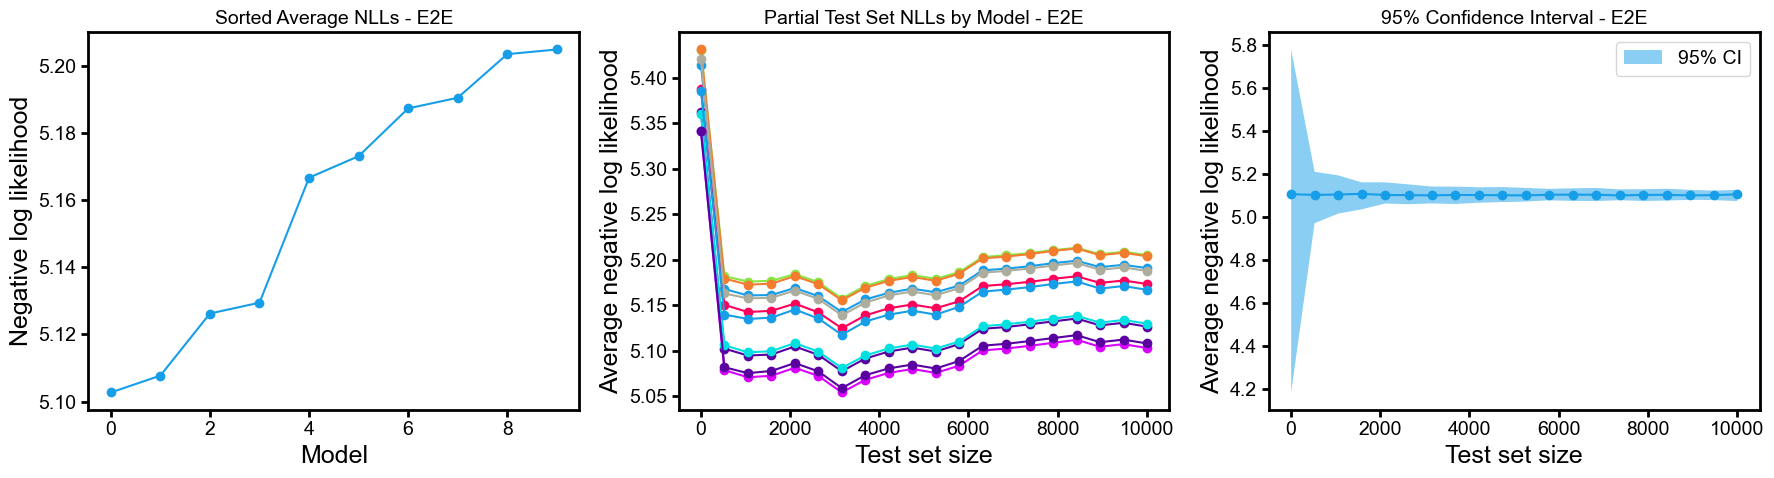

Results for E2E:
Mutual information: 1.1662 bits
Lower bound: 1.1300 bits
Upper bound: 1.2033 bits
Confidence interval: 0.0732 bits




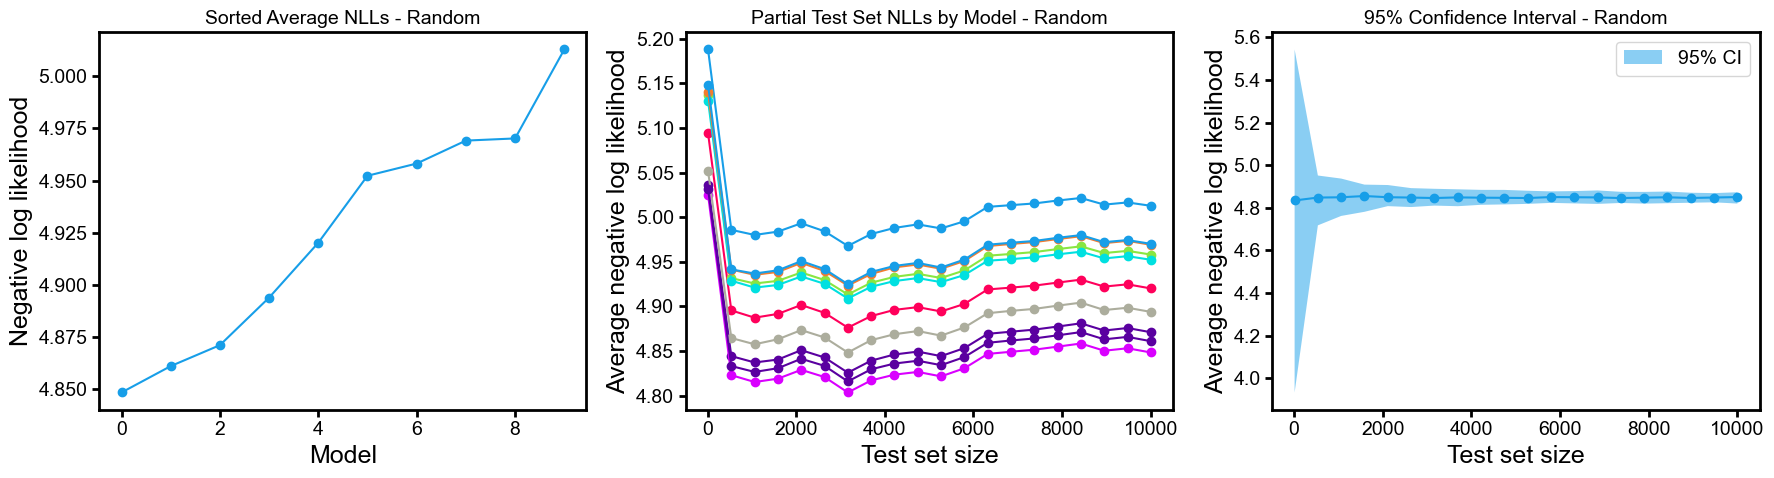

Results for Random:
Mutual information: 1.1020 bits
Lower bound: 1.0735 bits
Upper bound: 1.1477 bits
Confidence interval: 0.0742 bits




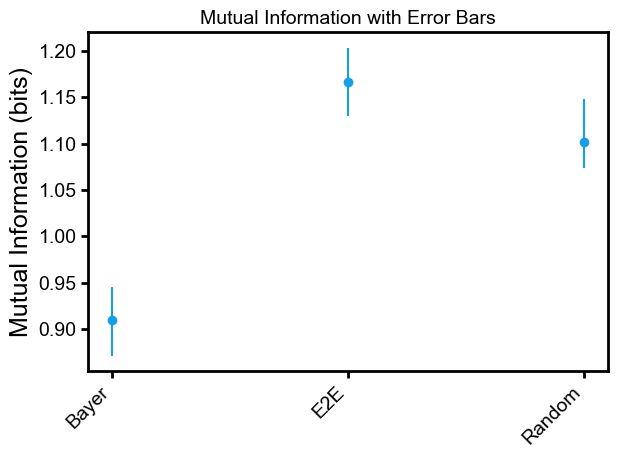

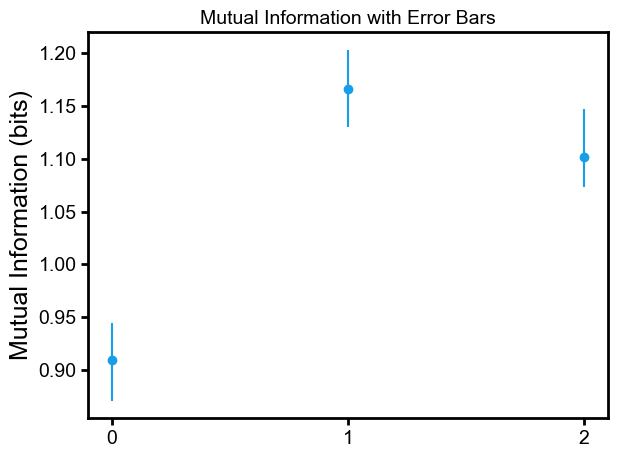

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from cleanplots import *
import glob


# List of results files
results_files = glob.glob('/home/anonymous_user/Workspace/PYTHON/EncodingInformation/color_filter_array/mi_results/*.npz')
results_files = [file for file in results_files if 'tuned' in file]
results_files = [file for file in results_files if 'ideal' not in file]
results_files.sort()
# List to hold data from each results file
results_list = []

# Labels for the results files
labels = []

for file in results_files:
    # Load results from file
    results = np.load(file)
    data = {}
    data['average_nlls'] = results['average_nlls']
    data['partial_test_set_nlls_by_model'] = results['partial_test_set_nlls_by_model']
    data['test_set_sizes'] = results['test_set_sizes']
    data['mean_nll_dist_by_size'] = results['mean_nll_dist_by_size']
    data['mean_nll_dist_by_size_conf_low'] = results['mean_nll_dist_by_size_conf_low']
    data['mean_nll_dist_by_size_conf_high'] = results['mean_nll_dist_by_size_conf_high']
    data['mutual_information'] = results['mutual_information']
    data['mutual_information_conf_low'] = results['mutual_information_conf_low']
    data['mutual_information_conf_high'] = results['mutual_information_conf_high']
    data['filter_matrix'] = results['filter_matrix']
    results_list.append(data)
    
    # Extract label from filename
    label = file.split('/')[-1].replace('prerendered_', '').replace('.npz', '')
    labels.append(label)

labels = ['Bayer', 'E2E','Random']
# Lists to collect mutual information and error bars
mutual_informations = []
lower_bounds = []
upper_bounds = []

# Plotting for each results file
for idx, data in enumerate(results_list):
    label = labels[idx]
    
    fig, axs = plt.subplots(1, 3, figsize=(18, 5))

    # Plot sorted average NLLs
    axs[0].plot(np.sort(data['average_nlls']), '-o')
    axs[0].set_xlabel('Model')
    axs[0].set_ylabel('Negative log likelihood')
    axs[0].set_title(f'Sorted Average NLLs - {label}')

    # Plot test set size vs. partial NLLs
    for i, partial_nlls in enumerate(data['partial_test_set_nlls_by_model']):
        axs[1].plot(data['test_set_sizes'], partial_nlls, '-o', label=f'Model {i}')
    axs[1].set_xlabel('Test set size')
    axs[1].set_ylabel('Average negative log likelihood')
    axs[1].set_title(f'Partial Test Set NLLs by Model - {label}')

    # Plot the 95% confidence interval
    axs[2].plot(data['test_set_sizes'], np.median(data['mean_nll_dist_by_size'], axis=1), '-o')
    axs[2].fill_between(data['test_set_sizes'], data['mean_nll_dist_by_size_conf_low'], data['mean_nll_dist_by_size_conf_high'], alpha=0.5, label='95% CI')
    axs[2].set_xlabel('Test set size')
    axs[2].set_ylabel('Average negative log likelihood')
    axs[2].legend()
    axs[2].set_title(f'95% Confidence Interval - {label}')

    plt.tight_layout()
    plt.show()

    
    # Collect mutual information and error bounds
    mutual_informations.append(data['mutual_information'])
    lower_bounds.append(data['mutual_information_conf_low'])
    upper_bounds.append(data['mutual_information_conf_high'])
    
    # Print mutual information results
    print(f'Results for {label}:')
    print('Mutual information: {:.4f} bits'.format(data['mutual_information']))
    print('Lower bound: {:.4f} bits'.format(data['mutual_information_conf_low']))
    print('Upper bound: {:.4f} bits'.format(data['mutual_information_conf_high']))
    print('Confidence interval: {:.4f} bits'.format(data['mutual_information_conf_high'] - data['mutual_information_conf_low']))
    print('\n')

# Compute error bars
error_lower = [mi - lb for mi, lb in zip(mutual_informations, lower_bounds)]
error_upper = [ub - mi for mi, ub in zip(mutual_informations, upper_bounds)]

# Plot mutual information with error bars for all results files
x = np.arange(len(mutual_informations))

fig, ax = plt.subplots()
ax.errorbar(x, mutual_informations, yerr=[error_lower, error_upper], fmt='o')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.set_ylabel('Mutual Information (bits)')
ax.set_title('Mutual Information with Error Bars')
plt.tight_layout()
plt.show()

fig, ax = plt.subplots()
ax.errorbar(x, mutual_informations, yerr=[error_lower, error_upper], fmt='o')
ax.set_xticks(x)
# ax.set_xticklabels(labels, rotation=45, ha='right')
ax.set_ylabel('Mutual Information (bits)')
ax.set_title('Mutual Information with Error Bars')
plt.tight_layout()
plt.show()


Results for /home/anonymous_user/Workspace/PYTHON/EncodingInformation/color_filter_array/recon_results/bayer_filter_1000_photons_replicate_1.npz:
MSE: 0.0001 (95% CI: 0.0001 - 0.0001)
SSIM: 0.9668 (95% CI: 0.9665 - 0.9672)
PSNR: 47.4927 (95% CI: 47.3997 - 47.5967)
Results for /home/anonymous_user/Workspace/PYTHON/EncodingInformation/color_filter_array/recon_results/e2e_1000_photons_test_fast_mask_lr.npz:
MSE: 0.0001 (95% CI: 0.0001 - 0.0001)
SSIM: 0.9703 (95% CI: 0.9700 - 0.9706)
PSNR: 47.8847 (95% CI: 47.7824 - 47.9809)
Results for /home/anonymous_user/Workspace/PYTHON/EncodingInformation/color_filter_array/recon_results/random_filter_1000_photons_replicate_1.npz:
MSE: 0.0001 (95% CI: 0.0001 - 0.0001)
SSIM: 0.9685 (95% CI: 0.9682 - 0.9689)
PSNR: 47.6584 (95% CI: 47.5555 - 47.7615)


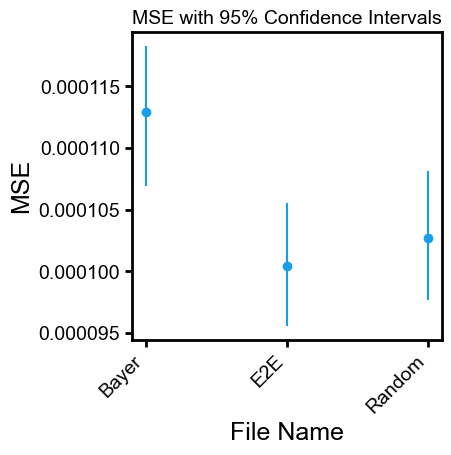

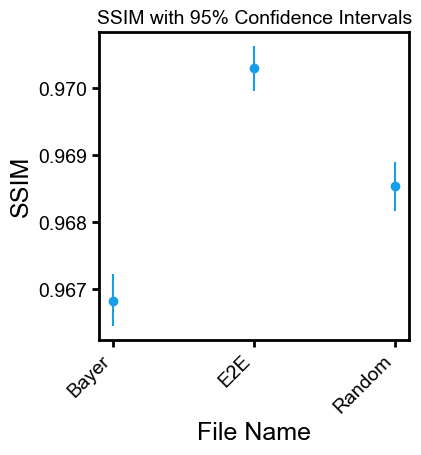

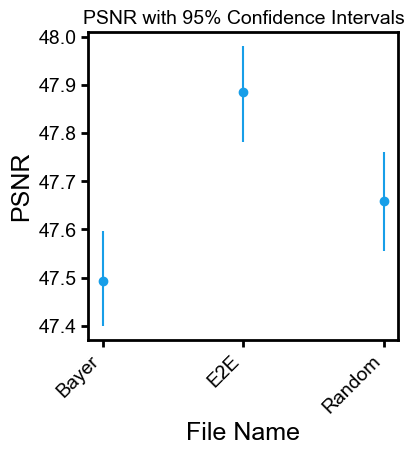

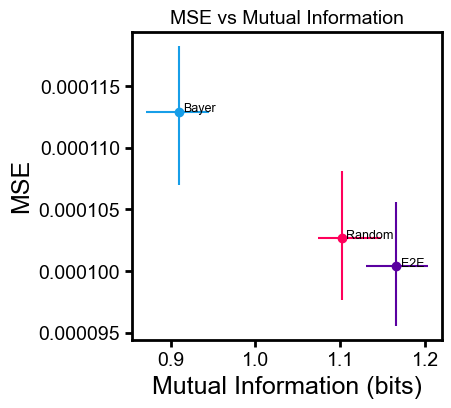

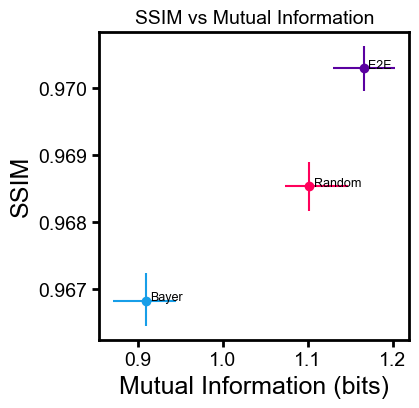

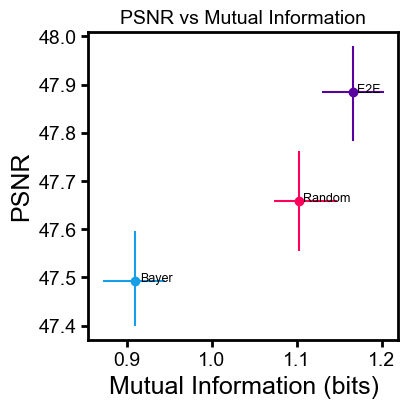

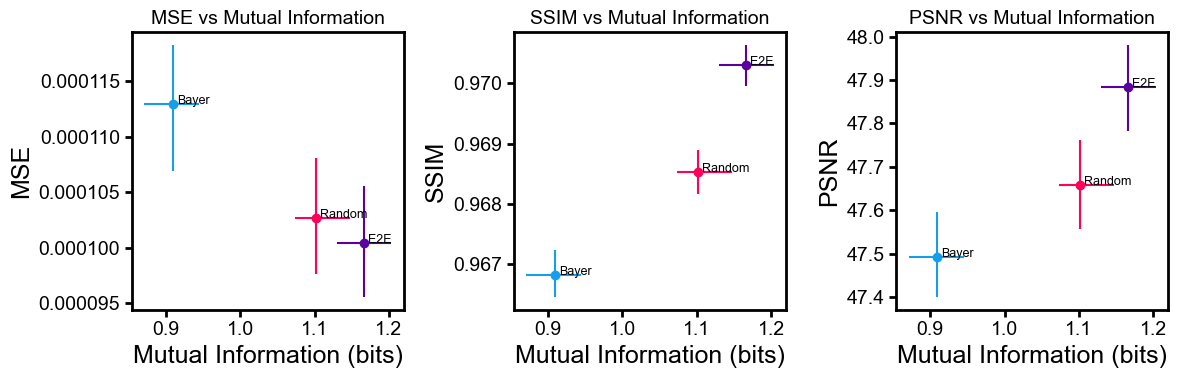

In [24]:
import glob
import numpy as np
import matplotlib.pyplot as plt
from cleanplots import *

recon_result_files = ['/home/anonymous_user/Workspace/PYTHON/EncodingInformation/color_filter_array/recon_results/bayer_filter_1000_photons_replicate_1.npz',
                      '/home/anonymous_user/Workspace/PYTHON/EncodingInformation/color_filter_array/recon_results/e2e_1000_photons_test_fast_mask_lr.npz',
                      '/home/anonymous_user/Workspace/PYTHON/EncodingInformation/color_filter_array/recon_results/random_filter_1000_photons_replicate_1.npz'
                      ]
recon_result_files.sort()

mse_means, mse_lowers, mse_uppers = [], [], []
ssim_means, ssim_lowers, ssim_uppers = [], [], []
psnr_means, psnr_lowers, psnr_uppers = [], [], []



for file in recon_result_files:
    result = np.load(file)

    mse_values = np.array(result['patch_list_mse'])
    ssim_values = np.array(result['patch_list_ssim'])
    psnr_values = np.array(result['patch_list_psnr'])
    # replace inf psnr values with 100
    psnr_values[np.isinf(psnr_values)] = 100

    # calculate the confidence interval of the mean by sampling with replacement
    def bootstrap_confidence_interval(data, num_samples=100, confidence_level=0.95):
        means = []
        n = len(data)
        for _ in range(num_samples):
            sample = np.random.choice(data, size=n, replace=True)
            means.append(np.mean(sample))
        lower_bound = np.percentile(means, (1 - confidence_level) / 2 * 100)
        upper_bound = np.percentile(means, (1 + confidence_level) / 2 * 100)
        return np.mean(data), lower_bound, upper_bound

    num_samples = 1000
    mse_mean, mse_lower, mse_upper = bootstrap_confidence_interval(mse_values, num_samples=num_samples)
    ssim_mean, ssim_lower, ssim_upper = bootstrap_confidence_interval(ssim_values, num_samples=num_samples)
    psnr_mean, psnr_lower, psnr_upper = bootstrap_confidence_interval(psnr_values, num_samples=num_samples)

    mse_means.append(mse_mean)
    mse_lowers.append(mse_lower)
    mse_uppers.append(mse_upper)
    ssim_means.append(ssim_mean)
    ssim_lowers.append(ssim_lower)
    ssim_uppers.append(ssim_upper)
    psnr_means.append(psnr_mean)
    psnr_lowers.append(psnr_lower)
    psnr_uppers.append(psnr_upper)

    print(f"Results for {file}:")
    print(f"MSE: {mse_mean:.4f} (95% CI: {mse_lower:.4f} - {mse_upper:.4f})")
    print(f"SSIM: {ssim_mean:.4f} (95% CI: {ssim_lower:.4f} - {ssim_upper:.4f})")
    print(f"PSNR: {psnr_mean:.4f} (95% CI: {psnr_lower:.4f} - {psnr_upper:.4f})")

# Plot MSE with confidence intervals
plt.figure(figsize=(4, 4))
plt.errorbar(range(len(mse_means)), mse_means, yerr=[np.array(mse_means) - np.array(mse_lowers), np.array(mse_uppers) - np.array(mse_means)], fmt='o')
plt.xticks(range(len(recon_result_files)), labels, rotation=45, ha='right')
plt.xlabel('File Name')
plt.ylabel('MSE')
plt.title('MSE with 95% Confidence Intervals')
plt.savefig('MSE_with_CI.pdf')
plt.show()

# Plot SSIM with confidence intervals
plt.figure(figsize=(4, 4))
plt.errorbar(range(len(ssim_means)), ssim_means, yerr=[np.array(ssim_means) - np.array(ssim_lowers), np.array(ssim_uppers) - np.array(ssim_means)], fmt='o')
plt.xticks(range(len(recon_result_files)), labels, rotation=45, ha='right')
plt.xlabel('File Name')
plt.ylabel('SSIM')
plt.title('SSIM with 95% Confidence Intervals')
plt.savefig('SSIM_with_CI.pdf')
plt.show()

# Plot PSNR with confidence intervals
plt.figure(figsize=(4, 4))
plt.errorbar(range(len(psnr_means)), psnr_means, yerr=[np.array(psnr_means) - np.array(psnr_lowers), np.array(psnr_uppers) - np.array(psnr_means)], fmt='o')
plt.xticks(range(len(recon_result_files)), labels, rotation=45, ha='right')
plt.xlabel('File Name')
plt.ylabel('PSNR')
plt.title('PSNR with 95% Confidence Intervals')
plt.savefig('PSNR_with_CI.pdf')
plt.show()

# Plot MSE vs Mutual Information
plt.figure(figsize=(4, 4))
for i, (mi, mse, mse_lower, mse_upper, mi_lower, mi_upper) in enumerate(zip(mutual_informations, mse_means, mse_lowers, mse_uppers, lower_bounds, upper_bounds)):
    if labels[i] == 'ideal_1000_photons_replicate_1':
        continue
    plt.errorbar(mi, mse, xerr=[[mi - mi_lower], [mi_upper - mi]], yerr=[[mse - mse_lower], [mse_upper - mse]], fmt='o')
    plt.text(mi + 0.005, mse, labels[i], fontsize=9)
plt.xlabel('Mutual Information (bits)')
plt.ylabel('MSE')
plt.title('MSE vs Mutual Information')
plt.savefig('MSE_vs_MI.pdf')
plt.show()

# Plot SSIM vs Mutual Information
plt.figure(figsize=(4, 4))
for i, (mi, ssim, ssim_lower, ssim_upper, mi_lower, mi_upper) in enumerate(zip(mutual_informations, ssim_means, ssim_lowers, ssim_uppers, lower_bounds, upper_bounds)):
    if labels[i] == 'ideal_1000_photons_replicate_1':
        continue
    plt.errorbar(mi, ssim, xerr=[[mi - mi_lower], [mi_upper - mi]], yerr=[[ssim - ssim_lower], [ssim_upper - ssim]], fmt='o')
    plt.text(mi + 0.005, ssim, labels[i], fontsize=9)
plt.xlabel('Mutual Information (bits)')
plt.ylabel('SSIM')
plt.title('SSIM vs Mutual Information')
plt.savefig('SSIM_vs_MI.pdf')
plt.show()

# Plot PSNR vs Mutual Information
plt.figure(figsize=(4, 4))
for i, (mi, psnr, psnr_lower, psnr_upper, mi_lower, mi_upper) in enumerate(zip(mutual_informations, psnr_means, psnr_lowers, psnr_uppers, lower_bounds, upper_bounds)):
    if labels[i] == 'ideal_1000_photons_replicate_1':
        continue
    plt.errorbar(mi, psnr, xerr=[[mi - mi_lower], [mi_upper - mi]], yerr=[[psnr - psnr_lower], [psnr_upper - psnr]], fmt='o')
    plt.text(mi + 0.005, psnr, labels[i], fontsize=9)
plt.xlabel('Mutual Information (bits)')
plt.ylabel('PSNR')
plt.title('PSNR vs Mutual Information')
plt.savefig('PSNR_vs_MI.pdf')
plt.show()

# Combined MI vs Metrics plot
fig, axs = plt.subplots(1, 3, figsize=(12, 4), sharex=True)

# MSE vs Mutual Information
for i, (mi, mse, mse_lower, mse_upper, mi_lower, mi_upper) in enumerate(zip(mutual_informations, mse_means, mse_lowers, mse_uppers, lower_bounds, upper_bounds)):
    if labels[i] == 'ideal_1000_photons_replicate_1':
        continue
    axs[0].errorbar(mi, mse, xerr=[[mi - mi_lower], [mi_upper - mi]], yerr=[[mse - mse_lower], [mse_upper - mse]], fmt='o')
    axs[0].text(mi + 0.005, mse, labels[i], fontsize=9)
axs[0].set_xlabel('Mutual Information (bits)')
axs[0].set_ylabel('MSE')
axs[0].set_title('MSE vs Mutual Information')

# SSIM vs Mutual Information
for i, (mi, ssim, ssim_lower, ssim_upper, mi_lower, mi_upper) in enumerate(zip(mutual_informations, ssim_means, ssim_lowers, ssim_uppers, lower_bounds, upper_bounds)):
    if labels[i] == 'ideal_1000_photons_replicate_1':
        continue
    axs[1].errorbar(mi, ssim, xerr=[[mi - mi_lower], [mi_upper - mi]], yerr=[[ssim - ssim_lower], [ssim_upper - ssim]], fmt='o')
    axs[1].text(mi + 0.005, ssim, labels[i], fontsize=9)
axs[1].set_xlabel('Mutual Information (bits)')
axs[1].set_ylabel('SSIM')
axs[1].set_title('SSIM vs Mutual Information')

# PSNR vs Mutual Information
for i, (mi, psnr, psnr_lower, psnr_upper, mi_lower, mi_upper) in enumerate(zip(mutual_informations, psnr_means, psnr_lowers, psnr_uppers, lower_bounds, upper_bounds)):
    if labels[i] == 'ideal_1000_photons_replicate_1':
        continue
    axs[2].errorbar(mi, psnr, xerr=[[mi - mi_lower], [mi_upper - mi]], yerr=[[psnr - psnr_lower], [psnr_upper - psnr]], fmt='o')
    axs[2].text(mi + 0.005, psnr, labels[i], fontsize=9)
axs[2].set_xlabel('Mutual Information (bits)')
axs[2].set_ylabel('PSNR')
axs[2].set_title('PSNR vs Mutual Information')

plt.tight_layout()
plt.savefig('MI_vs_Metrics.pdf')
plt.show()


['/home/anonymous_user/Workspace/PYTHON/EncodingInformation/color_filter_array/mi_results/tuned_model_ideal_1000_photons.npz', '/home/anonymous_user/Workspace/PYTHON/EncodingInformation/color_filter_array/mi_results/tuned_model_ideal_1000_photons_initialization.npz', '/home/anonymous_user/Workspace/PYTHON/EncodingInformation/color_filter_array/mi_results/tuned_model_ideal_1000_photons_intermediate.npz']


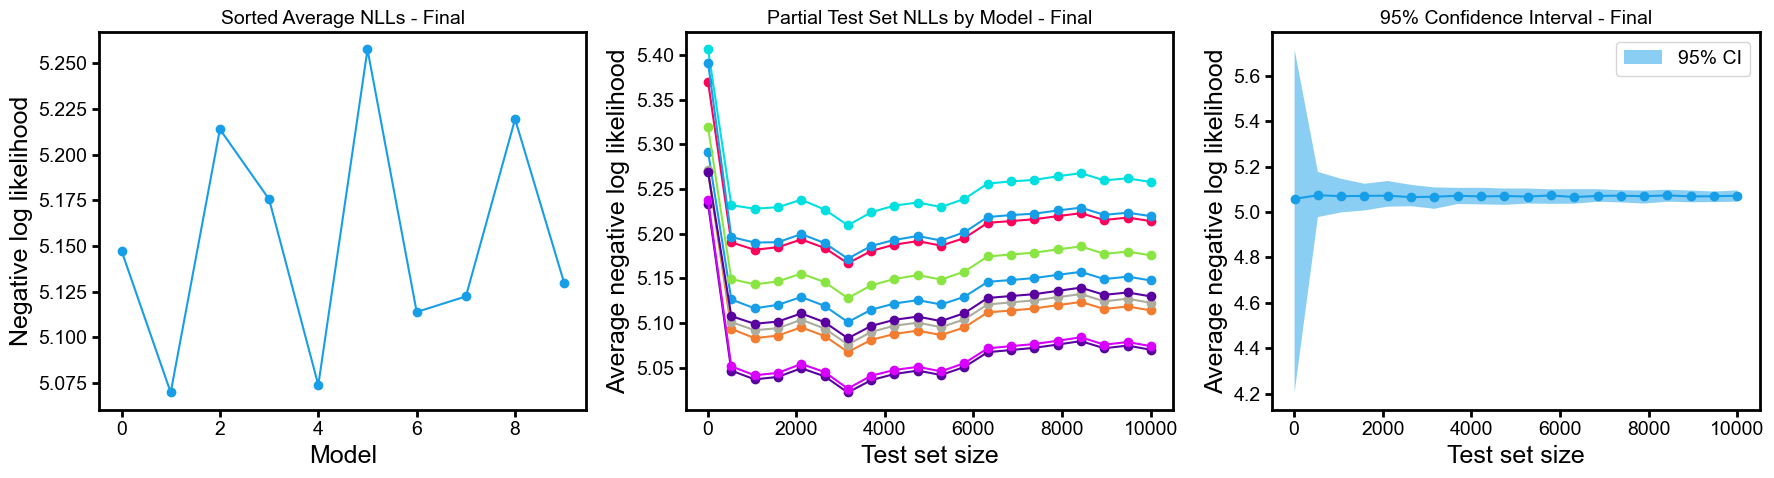

Results for Final:
Mutual information: 1.2135 bits
Lower bound: 1.1649 bits
Upper bound: 1.2524 bits
Confidence interval: 0.0876 bits




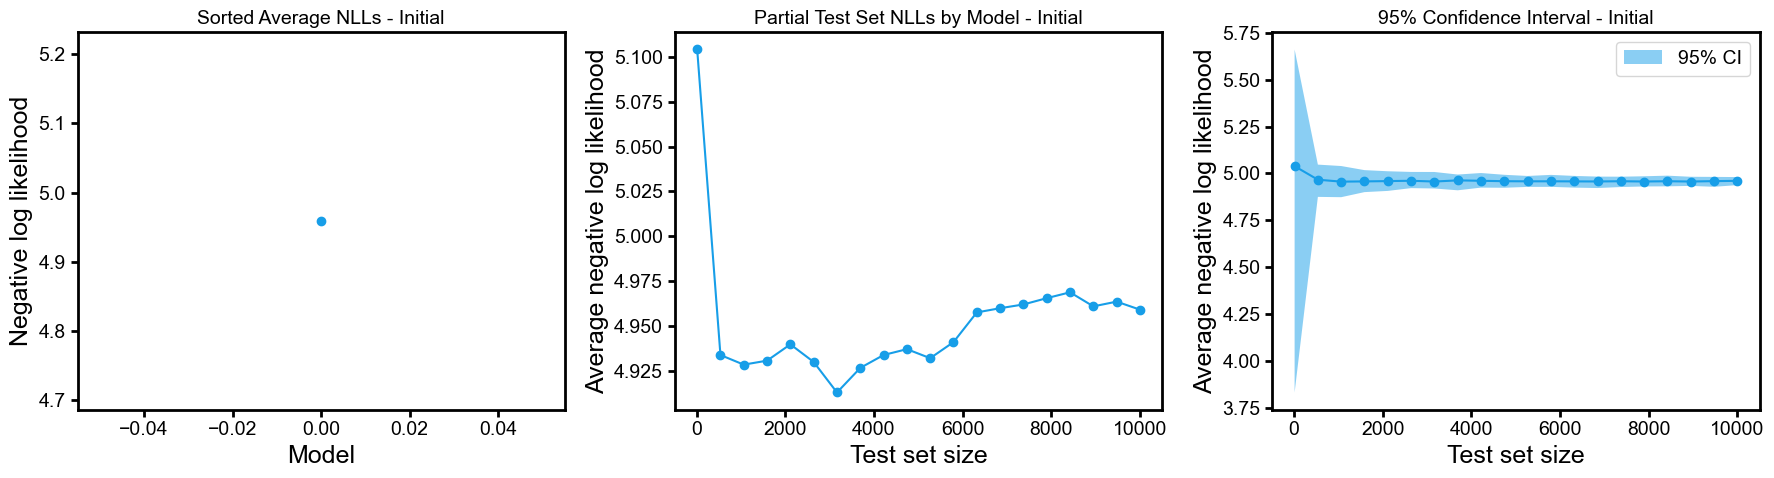

Results for Initial:
Mutual information: 1.2922 bits
Lower bound: 1.2412 bits
Upper bound: 1.3188 bits
Confidence interval: 0.0776 bits




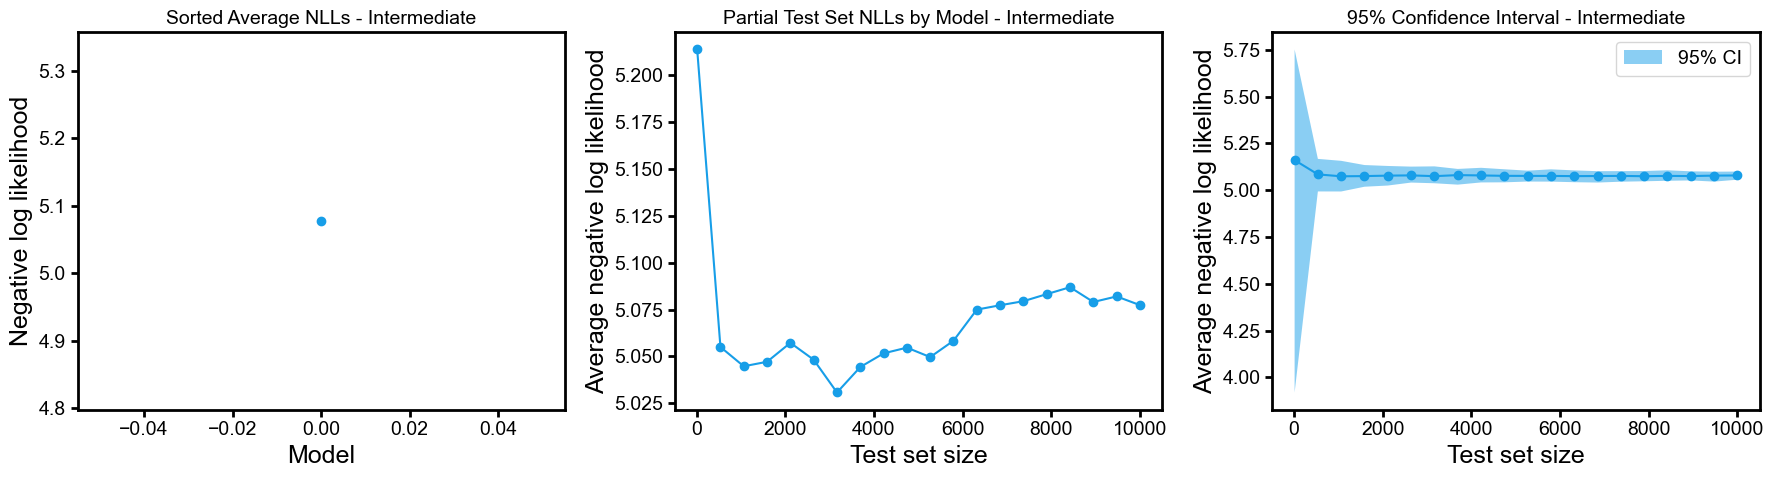

Results for Intermediate:
Mutual information: 1.3496 bits
Lower bound: 1.3299 bits
Upper bound: 1.4072 bits
Confidence interval: 0.0774 bits




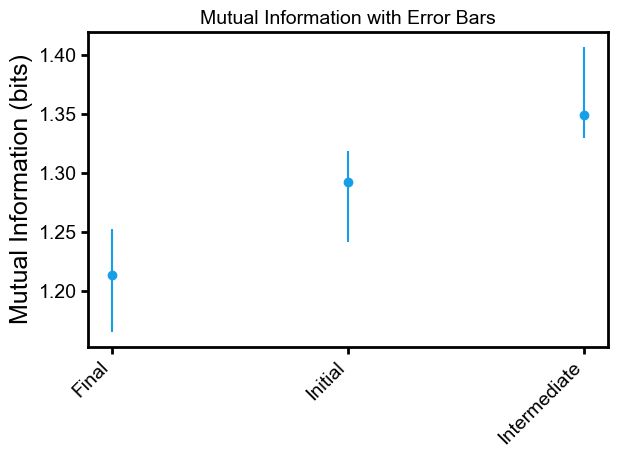

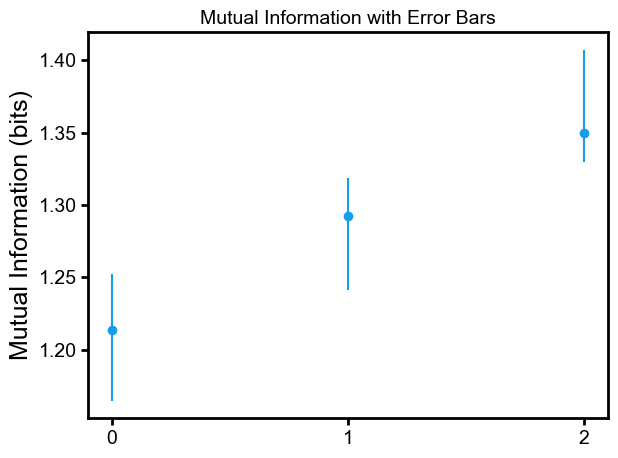

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from cleanplots import *
import glob


# List of results files
results_files = glob.glob('/home/anonymous_user/Workspace/PYTHON/EncodingInformation/color_filter_array/mi_results/*.npz')
results_files = [file for file in results_files if 'tuned' in file]
results_files = [file for file in results_files if 'ideal' in file]
results_files.sort()
print(results_files)
# List to hold data from each results file
results_list = []


# Labels for the results files
labels = []

for file in results_files:
    # Load results from file
    results = np.load(file)
    data = {}
    data['average_nlls'] = results['average_nlls']
    data['partial_test_set_nlls_by_model'] = results['partial_test_set_nlls_by_model']
    data['test_set_sizes'] = results['test_set_sizes']
    data['mean_nll_dist_by_size'] = results['mean_nll_dist_by_size']
    data['mean_nll_dist_by_size_conf_low'] = results['mean_nll_dist_by_size_conf_low']
    data['mean_nll_dist_by_size_conf_high'] = results['mean_nll_dist_by_size_conf_high']
    data['mutual_information'] = results['mutual_information']
    data['mutual_information_conf_low'] = results['mutual_information_conf_low']
    data['mutual_information_conf_high'] = results['mutual_information_conf_high']
    data['filter_matrix'] = results['filter_matrix']
    results_list.append(data)
    
    # Extract label from filename
    label = file.split('/')[-1].replace('prerendered_', '').replace('.npz', '')
    labels.append(label)

labels = ['Final', 'Initial', 'Intermediate']
# Lists to collect mutual information and error bars
mutual_informations = []
lower_bounds = []
upper_bounds = []

# Plotting for each results file
for idx, data in enumerate(results_list):
    label = labels[idx]
    
    fig, axs = plt.subplots(1, 3, figsize=(18, 5))

    # Plot sorted average NLLs
    # axs[0].plot(np.sort(data['average_nlls']), '-o')
    axs[0].plot(data['average_nlls'], '-o')
    axs[0].set_xlabel('Model')
    axs[0].set_ylabel('Negative log likelihood')
    axs[0].set_title(f'Sorted Average NLLs - {label}')

    # Plot test set size vs. partial NLLs
    for i, partial_nlls in enumerate(data['partial_test_set_nlls_by_model']):
        axs[1].plot(data['test_set_sizes'], partial_nlls, '-o', label=f'Model {i}')
    axs[1].set_xlabel('Test set size')
    axs[1].set_ylabel('Average negative log likelihood')
    axs[1].set_title(f'Partial Test Set NLLs by Model - {label}')

    # Plot the 95% confidence interval
    axs[2].plot(data['test_set_sizes'], np.median(data['mean_nll_dist_by_size'], axis=1), '-o')
    axs[2].fill_between(data['test_set_sizes'], data['mean_nll_dist_by_size_conf_low'], data['mean_nll_dist_by_size_conf_high'], alpha=0.5, label='95% CI')
    axs[2].set_xlabel('Test set size')
    axs[2].set_ylabel('Average negative log likelihood')
    axs[2].legend()
    axs[2].set_title(f'95% Confidence Interval - {label}')

    plt.tight_layout()
    plt.show()

    
    # Collect mutual information and error bounds
    mutual_informations.append(data['mutual_information'])
    lower_bounds.append(data['mutual_information_conf_low'])
    upper_bounds.append(data['mutual_information_conf_high'])
    
    # Print mutual information results
    print(f'Results for {label}:')
    print('Mutual information: {:.4f} bits'.format(data['mutual_information']))
    print('Lower bound: {:.4f} bits'.format(data['mutual_information_conf_low']))
    print('Upper bound: {:.4f} bits'.format(data['mutual_information_conf_high']))
    print('Confidence interval: {:.4f} bits'.format(data['mutual_information_conf_high'] - data['mutual_information_conf_low']))
    print('\n')

# Compute error bars
error_lower = [mi - lb for mi, lb in zip(mutual_informations, lower_bounds)]
error_upper = [ub - mi for mi, ub in zip(mutual_informations, upper_bounds)]

# Plot mutual information with error bars for all results files
x = np.arange(len(mutual_informations))

fig, ax = plt.subplots()
ax.errorbar(x, mutual_informations, yerr=[error_lower, error_upper], fmt='o')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.set_ylabel('Mutual Information (bits)')
ax.set_title('Mutual Information with Error Bars')
plt.tight_layout()
plt.show()

fig, ax = plt.subplots()
ax.errorbar(x, mutual_informations, yerr=[error_lower, error_upper], fmt='o')
ax.set_xticks(x)
# ax.set_xticklabels(labels, rotation=45, ha='right')
ax.set_ylabel('Mutual Information (bits)')
ax.set_title('Mutual Information with Error Bars')
plt.tight_layout()
plt.show()


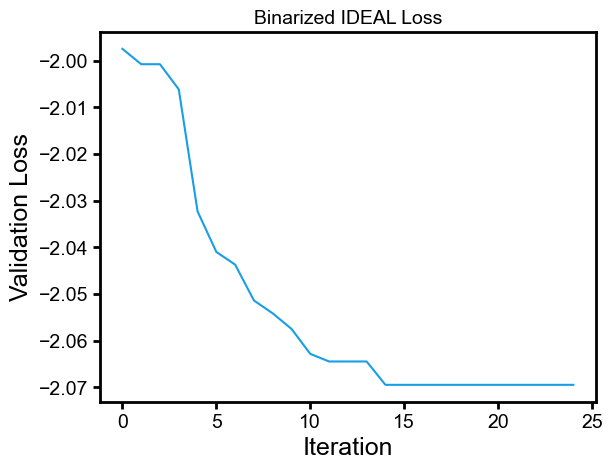

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
img_files = glob('/home/anonymous_user/Workspace/PYTHON/EncodingInformation/color_filter_array/wandb/run-20241017_153733-acj1dc7r/files/media/images/*.png')
sorted_img_files = sorted(img_files, key=lambda x: int(x.split('sensor_')[1].split('_')[0]))
epochs = [int(x.split('sensor_')[1].split('_')[0]) for x in sorted_img_files]
val_losses = np.load('val_losses.npy')[:25]
plt.plot( val_losses)
plt.xlabel('Iteration')
plt.ylabel('Validation Loss')
plt.title('Binarized IDEAL Loss')
plt.show()
